In [29]:
!pip install kaggle
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
# Params
EPOCHS = 50
BATCH_SIZE = 32
SHUFFLE = True
IMAGE_SIZE = (150, 150)

In [31]:
import zipfile
import os

# Define the path to the zip file and the target directory
zip_file_path = '/content/brain-tumor-mri-dataset.zip'
extract_dir = '/content/brain-tumor-mri-dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [32]:
# Define the paths to the training and testing directories after extraction
training_dir = os.path.join(extract_dir, 'Training')
testing_dir = os.path.join(extract_dir, 'Testing')

# Function to count images per class in a given directory
def count_images_per_class(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images per class for training and testing directories
training_class_counts = count_images_per_class(training_dir)
testing_class_counts = count_images_per_class(testing_dir)

print("Training Class Counts:")
for class_name, count in training_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Class Counts:")
for class_name, count in testing_class_counts.items():
    print(f"{class_name}: {count} images")

# Check for balance in the training set
training_min_count = min(training_class_counts.values())
training_max_count = max(training_class_counts.values())

print(f"\nTraining Set - Minimum number of images in a class: {training_min_count}")
print(f"Training Set - Maximum number of images in a class: {training_max_count}")

# Check for balance in the testing set
testing_min_count = min(testing_class_counts.values())
testing_max_count = max(testing_class_counts.values())

print(f"\nTesting Set - Minimum number of images in a class: {testing_min_count}")
print(f"Testing Set - Maximum number of images in a class: {testing_max_count}")


Training Class Counts:
glioma: 1321 images
pituitary: 1457 images
meningioma: 1339 images
notumor: 1595 images

Testing Class Counts:
glioma: 300 images
pituitary: 300 images
meningioma: 306 images
notumor: 405 images

Training Set - Minimum number of images in a class: 1321
Training Set - Maximum number of images in a class: 1595

Testing Set - Minimum number of images in a class: 300
Testing Set - Maximum number of images in a class: 405


In [33]:
import os
import random
import shutil

# Data paths
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Function to reduce the number of images in each class to match the smallest class
def balance_classes(base_dir, target_count):
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            current_count = len(image_files)

            if current_count > target_count:
                # Randomly shuffle and select images to keep
                images_to_keep = random.sample(image_files, target_count)
                images_to_remove = set(image_files) - set(images_to_keep)

                # Remove the excess images
                for image_file in images_to_remove:
                    os.remove(os.path.join(class_path, image_file))

# Path to your training and testing directories
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Target count is the number of images in the smallest class (glioma: 1321 images)
target_count = 1321

# Reduce the images in the training and testing directories
balance_classes(train_dir, target_count)
balance_classes(test_dir, target_count)



In [34]:
# Function to count all images in a given directory
def count_all_images(base_dir):
    total_count = 0
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            num_images = len(os.listdir(class_path))
            total_count += num_images
            print(f"{class_name}: {num_images} images")
    return total_count

# Count all images in the training directory
total_images = count_all_images(training_dir)

print(f"\nTotal number of images across all classes in the training set: {total_images}")

glioma: 1321 images
pituitary: 1321 images
meningioma: 1321 images
notumor: 1321 images

Total number of images across all classes in the training set: 5284


In [35]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import cv2

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to a single channel or RGB image."""
    if image.ndim == 2:  # If the image is grayscale
        # Ensure the image is 8-bit
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    elif image.ndim == 3 and image.shape[-1] == 3:  # If the image is RGB
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        y, u, v = cv2.split(img_yuv)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(y)
        yuv_clahe = cv2.merge([cl, u, v])
        return cv2.cvtColor(yuv_clahe, cv2.COLOR_YUV2RGB)
    else:
        raise ValueError("Unsupported image format")

class CLAHEImageDataGenerator(Sequence):
    """Custom data generator that applies CLAHE to images."""
    def __init__(self, image_data_generator, directory, target_size, batch_size, class_mode='categorical', shuffle=True, clip_limit=2.0, tile_grid_size=(8, 8)):
        # Initialize the base class
        super().__init__()
        # Store parameters
        self.image_data_generator = image_data_generator
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

        # Initialize the data generator
        self.data_gen = self.image_data_generator.flow_from_directory(
            directory=self.directory,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode=self.class_mode,
            shuffle=self.shuffle
        )
        self.class_indices = self.data_gen.class_indices  # Store class indices

    def __len__(self):
        return len(self.data_gen)

    def __getitem__(self, index):
        x_batch, y_batch = self.data_gen[index]
        x_batch_clahe = np.zeros_like(x_batch)
        for i in range(x_batch.shape[0]):
            x_batch_clahe[i] = apply_clahe((x_batch[i] * 255).astype(np.uint8), clip_limit=self.clip_limit, tile_grid_size=self.tile_grid_size) / 255.0
        return x_batch_clahe, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.data_gen.on_epoch_end()

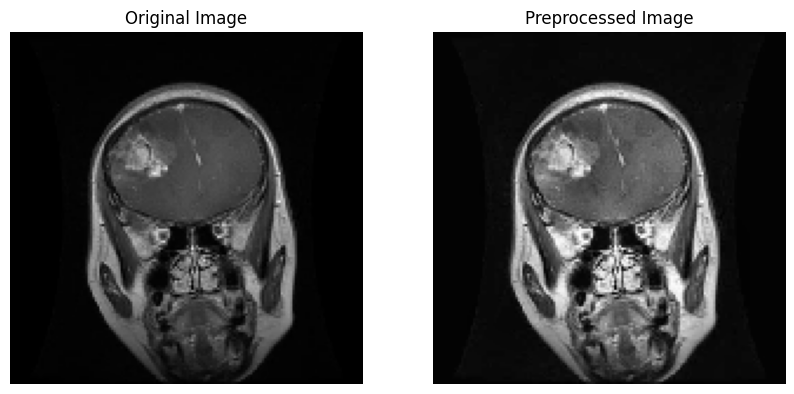

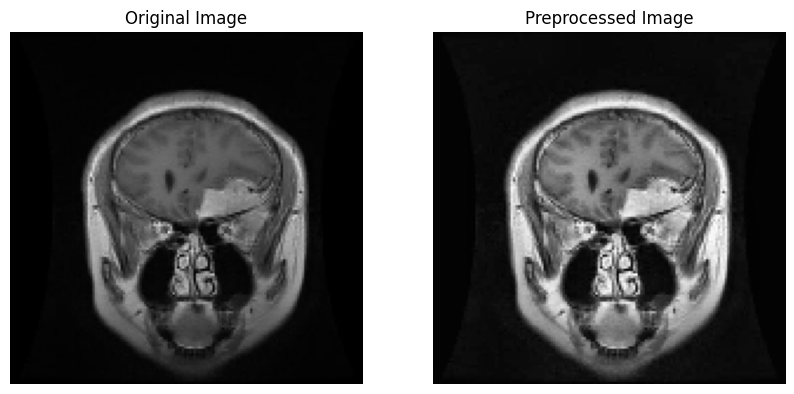

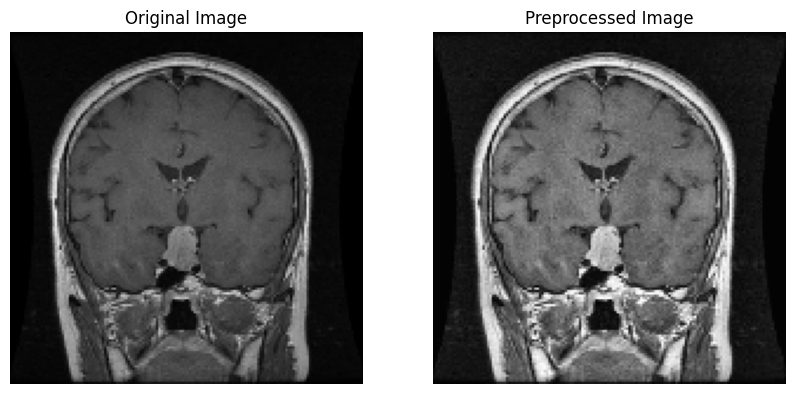

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def display_original_and_preprocessed(image_path, target_size, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Displays the original and CLAHE-preprocessed images side by side."""
    # Load and preprocess the image
    # Check if the file exists before trying to load it
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return  # Exit the function if the image is not found

    original_img = load_img(image_path, target_size=target_size)
    original_img_array = img_to_array(original_img).astype(np.uint8)

    # Apply CLAHE preprocessing
    preprocessed_img = apply_clahe(original_img_array, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

    # Display the images
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img_array.astype(np.uint8))
    plt.axis('off')

    # Preprocessed Image
    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Image")
    plt.imshow(preprocessed_img.astype(np.uint8))
    plt.axis('off')

    plt.show()

# Example usage
example_gli = '/content/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg'
# Try a different image in the 'meningioma' directory
example_metr='/content/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0000.jpg'  # Changed image file
example_pit='/content/brain-tumor-mri-dataset/Training/pituitary/Tr-piTr_0002.jpg'
example_no='/content/brain-tumor-mri-dataset/Training/notumor/Tr-noTr_0000.jpg'
display_original_and_preprocessed(example_gli, target_size=(150, 150))
display_original_and_preprocessed(example_metr, target_size=(150, 150))
display_original_and_preprocessed(example_pit, target_size=(150, 150))

In [37]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to a single channel or RGB image."""
    import cv2
    if image.ndim == 2:  # Grayscale image
        image = image.astype(np.uint8) if image.dtype != np.uint8 else image
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    elif image.ndim == 3 and image.shape[-1] == 3:  # RGB image
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        y, u, v = cv2.split(img_yuv)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(y)
        yuv_clahe = cv2.merge([cl, u, v])
        return cv2.cvtColor(yuv_clahe, cv2.COLOR_YUV2RGB)
    else:
        raise ValueError("Unsupported image format")

class CLAHEImageDataGenerator(Sequence):
    """Custom data generator that applies CLAHE to images."""
    def __init__(self, image_data_generator, directory, target_size, batch_size, class_mode='categorical', shuffle=True, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.data_gen = image_data_generator.flow_from_directory(
            directory=directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode,
            shuffle=shuffle
        )
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __len__(self):
        return len(self.data_gen)

    def __getitem__(self, index):
        x_batch, y_batch = self.data_gen[index]
        x_batch_clahe = np.array([apply_clahe((img * 255).astype(np.uint8), clip_limit=self.clip_limit, tile_grid_size=self.tile_grid_size) / 255.0 for img in x_batch])
        return x_batch_clahe, y_batch

    def on_epoch_end(self):
        self.data_gen.on_epoch_end()

class MultiInputDataGenerator(Sequence):
    def __init__(self, generator, batch_size):
        self.generator = generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        return (batch_x, batch_x), batch_y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Define ImageDataGenerators for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'
)

train_generator = CLAHEImageDataGenerator(
    datagen,
    train_dir,  # Path to your training data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE,
    clip_limit=2.0,
    tile_grid_size=(8, 8)
)

validation_generator = CLAHEImageDataGenerator(
    datagen,
    test_dir,  # Path to your testing data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE,
    clip_limit=2.0,
    tile_grid_size=(8, 8)
)

# Custom data generators for dual input
train_multi_input_gen = MultiInputDataGenerator(train_generator, batch_size=BATCH_SIZE)
val_multi_input_gen = MultiInputDataGenerator(validation_generator, batch_size=BATCH_SIZE)



Found 5284 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [38]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to count files in each directory
def count_files(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count files in training and testing directories
train_counts = count_files(train_dir)
test_counts = count_files(test_dir)

# Plotting class distributions with Pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Training Data Class Distribution', 'Testing Data Class Distribution'])

fig.add_trace(go.Pie(labels=list(train_counts.keys()), values=list(train_counts.values()), name="Training"),
              1, 1)
fig.add_trace(go.Pie(labels=list(test_counts.keys()), values=list(test_counts.values()), name="Testing"),
              1, 2)
fig.show()

In [39]:
# Data paths
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [40]:
import os
from PIL import Image

def get_image_sizes(base_dir):
    """Get sizes of all images in a directory, skipping subdirectories."""
    image_sizes = []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    try:
                        with Image.open(file_path) as img:
                            image_sizes.append(img.size)
                    except Exception as e:
                        print(f"Error opening file {file_path}: {e}")
    return image_sizes


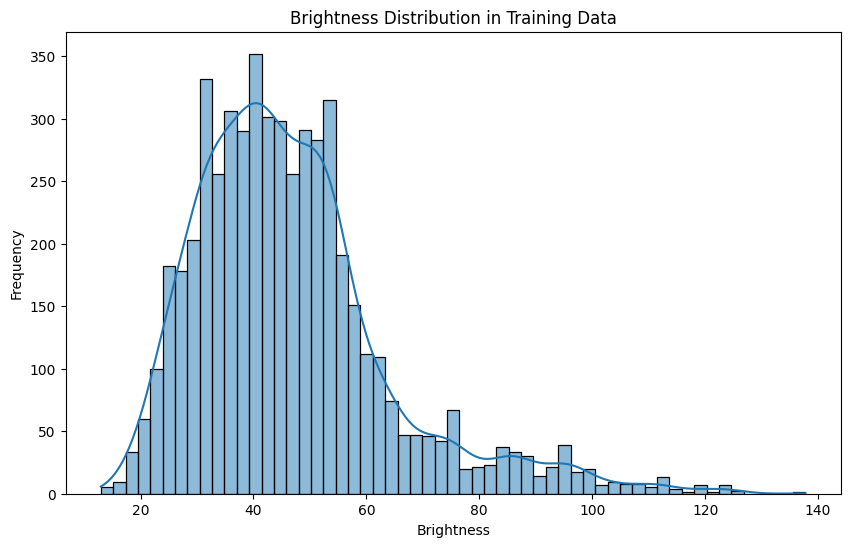

In [41]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate image brightness
def calculate_brightness(image):
    img = np.array(image)
    return np.mean(img)

# Analyze brightness
def analyze_brightness(base_dir):
    brightness_list = []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):  # Ensure it's a file
                    try:
                        with Image.open(img_path) as img:
                            brightness = calculate_brightness(img)
                            brightness_list.append(brightness)
                    except Exception as e:
                        print(f"Error processing file {img_path}: {e}")
    return brightness_list

# Data paths
train_dir = '/content/brain-tumor-mri-dataset/Training'

# Analyze brightness for training data
train_brightness = analyze_brightness(train_dir)

# Plot brightness distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_brightness, kde=True)
plt.title('Brightness Distribution in Training Data')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()


In [42]:
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate, BatchNormalization, GlobalAveragePooling2D

def create_pretrained_model_1(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:10]:
        layer.trainable = False

    for layer in base_model.layers[10:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    return base_model.input, x

def create_pretrained_model_2(input_shape):

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:10]:
        layer.trainable = False

    for layer in base_model.layers[10:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    return base_model.input, x

def create_hybrid_model(input_shape):
    input_1, output_1 = create_pretrained_model_1(input_shape)
    input_2, output_2 = create_pretrained_model_2(input_shape)

    combined = concatenate([output_1, output_2])
    z = Dense(256, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(4, activation='softmax')(z)

    model = Model(inputs=[input_1, input_2], outputs=z)
    return model

input_shape = (150, 150, 3)
hybrid_model = create_hybrid_model(input_shape)
hybrid_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 74, 74, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 74, 74, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 74, 74, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 72, 72, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 72, 72, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 72, 72, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 72, 72, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 72, 72, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 72, 72, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 35, 35, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 35, 35, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 35, 35, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 37,305,700 (142.31 MB)

 Trainable params: 35,507,140 (135.45 MB)

 Non-trainable params: 1,798,560 (6.86 MB)

In [43]:
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

callbacks = [checkpoint, early_stopping]

In [45]:
# Train the model
history = hybrid_model.fit(
    train_multi_input_gen,
#     steps_per_epoch=len(train_multi_input_gen),
    validation_data=val_multi_input_gen,
#     validation_steps=len(val_multi_input_gen),
    epochs=EPOCHS,

    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



166/166 ━━━━━━━━━━━━━━━━━━━━ 197s 727ms/step - accuracy: 0.5927 - loss: 1.1066 - val_accuracy: 0.3921 - val_loss: 5.3526
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.8526 - loss: 0.4503 - val_accuracy: 0.6476 - val_loss: 5.6112
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 80s 378ms/step - accuracy: 0.8520 - loss: 0.4809 - val_accuracy: 0.5538 - val_loss: 305.1523
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 77s 452ms/step - accuracy: 0.8731 - loss: 0.3985 - val_accuracy: 0.5789 - val_loss: 2.0395
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - accuracy: 0.8994 - loss: 0.3545 - val_accuracy: 0.8330 - val_loss: 0.5415
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.9049 - loss: 0.3088 - val_accuracy: 0.8497 - val_loss: 0.4654
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 371ms/step - accuracy: 0.9121 - loss: 0.2768 - val_accuracy: 0.6499 - val_loss: 1.3242
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 87s 513ms/step - accuracy: 0.9340 - loss: 0.2075 - 

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Reset the validation generator
val_multi_input_gen.on_epoch_end()

# Initialize lists to store validation images and labels
val_images_all = []
val_labels_all = []

# Fetch all validation data
for i in range(len(val_multi_input_gen)):
    (val_images, _), val_labels = val_multi_input_gen[i]
    val_images_all.append(val_images)
    val_labels_all.append(val_labels)

# Convert lists to numpy arrays
val_images_all = np.vstack(val_images_all)
val_labels_all = np.vstack(val_labels_all)

# Make predictions
val_preds = hybrid_model.predict([val_images_all, val_images_all])
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(val_labels_all, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_true_classes, val_preds_classes)
precision = precision_score(val_true_classes, val_preds_classes, average='weighted')
recall = recall_score(val_true_classes, val_preds_classes, average='weighted')
f1 = f1_score(val_true_classes, val_preds_classes, average='weighted')
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

class_report = classification_report(val_true_classes, val_preds_classes, target_names=class_names)
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(class_report)
print('Confusion Matrix:')
print(conf_matrix)

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step
Accuracy: 0.9359267734553776
Precision: 0.9418808236747138
Recall: 0.9359267734553776
F1 Score: 0.9369317666323428
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       300
  meningioma       0.83      0.96      0.89       306
     notumor       0.99      0.93      0.96       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311

Confusion Matrix:
[[265  34   0   1]
 [  3 295   3   5]
 [  3  21 377   4]
 [  3   7   0 290]]


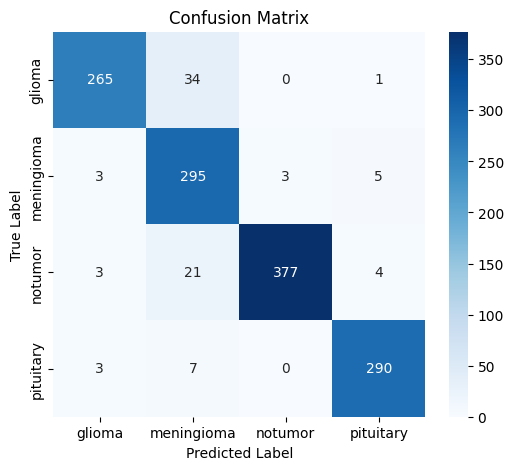

In [47]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plot_confusion_matrix(conf_matrix, class_names)

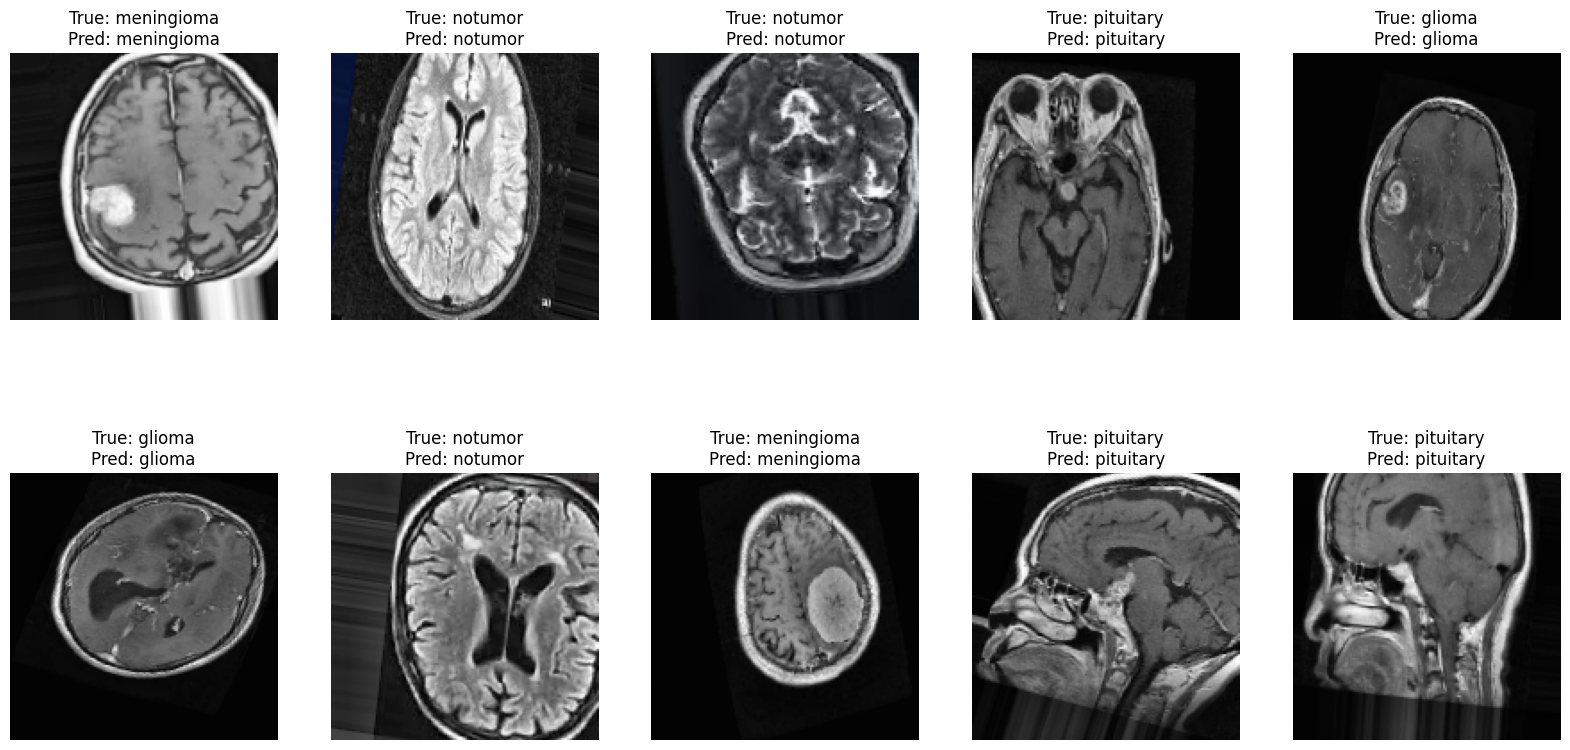

In [28]:
import random

# Plot random samples with actual and predicted labels
def plot_random_samples(images, true_labels, pred_labels, class_names, n=10):
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(images)), n)
    for i, idx in enumerate(indices):
        plt.subplot(2, n//2, i+1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plot_random_samples(val_images_all, val_true_classes, val_preds_classes, class_names)

In [ ]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [48]:
# prompt: how to download the model as a pickle file

import pickle

# Save the entire model as a pickle file
with open('hybrid_model.pkl', 'wb') as file:
  pickle.dump(hybrid_model, file)

# To load the model later:
# with open('hybrid_model.pkl', 'rb') as file:
#   loaded_model = pickle.load(file)


In [49]:
hybrid_model.save("trained_model.keras")

In [50]:
hybrid_model.save("trained_model.h5")